# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model. 
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
import warnings

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [2]:
df_news = pd.read_csv('./data/df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [3]:
df_meta = pd.read_csv('./data/df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [4]:
# CODE HERE
# Use as many coding cells as you need

MODEL_NAME = "cross-encoder/nli-deberta-v3-base"

# Device and model/tokenizer loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device).eval()

# Identify entailment index
id2label = (
    {int(k): v for k, v in model.config.id2label.items()}
    if hasattr(model.config, "id2label")
    else {0: "contradiction", 1: "neutral", 2: "entailment"}
)
entail_idx = [i for i, name in id2label.items() if "entail" in name.lower()]
assert len(entail_idx) == 1, f"No unique entailment label found in id2label={id2label}"
ENTAIL_IDX = entail_idx[0]

# Hypotheses
H_POS = "Overall, this news is positive for the company."
H_NEG = "Overall, this news is negative for the company."

# Batched inference helper with tqdm
@torch.no_grad()
def nli_entailment_prob(premises, hypothesis, batch_size=32, max_length=256):
    probs = []
    for i in tqdm(range(0, len(premises), batch_size), desc=f"Scoring: {hypothesis[:25]}..."):
        batch_prem = premises[i:i + batch_size]
        enc = tokenizer(
            batch_prem,
            [hypothesis] * len(batch_prem),
            truncation=True,
            max_length=max_length,
            padding=True,
            return_tensors="pt"
        ).to(device)

        logits = model(**enc).logits
        softmax = torch.nn.functional.softmax(logits, dim=-1)
        probs.extend(softmax[:, ENTAIL_IDX].detach().cpu().tolist())
    return probs

# Prepare titles
titles = df_news["TITLE"].fillna("").astype(str).tolist()

# Compute POS/NEG probabilities
pos_probs = nli_entailment_prob(titles, H_POS, batch_size=32, max_length=256)
neg_probs = nli_entailment_prob(titles, H_NEG, batch_size=32, max_length=256)

# Add columns to DataFrame
df_news["POSITIVE_PROB"] = pos_probs
df_news["NEGATIVE_PROB"] = neg_probs
df_news["SENTIMENT"] = df_news["POSITIVE_PROB"] - df_news["NEGATIVE_PROB"]

# Display a preview nicely in notebook
display(df_news[["TITLE", "POSITIVE_PROB", "NEGATIVE_PROB", "SENTIMENT"]].head(10))

Scoring: Overall, this news is neg...: 100%|████████████████████████████████████████████████████████████████████████████| 125/125 [03:27<00:00,  1.66s/it]


,TITLE,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,2 Dow Jones Stocks with Promising Prospects an...,0.002061,0.000463,0.001597
1,3 S&P 500 Stocks Skating on Thin Ice,0.000222,0.000234,-0.000012
2,3M Rises 15.8% YTD: Should You Buy the Stock N...,0.000322,0.000047,0.000275
3,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,0.000094,0.000047,0.000046
4,3 Cash-Producing Stocks with Questionable Fund...,0.000119,0.000313,-0.000194
5,Here's Why You Should Retain 3M Stock in Your ...,0.000185,0.000067,0.000118
6,"3M Co: A company with a sound balance sheet, a...",0.000582,0.000135,0.000447
7,"Rogers, Enviri, 3M, Gates Industrial Corporati...",0.000360,0.000082,0.000278
8,"3 ""Top Picks"" From Wall Street That Are Magnif...",0.000328,0.000033,0.000295
9,3M vs. Honeywell: Which Industrial Conglomerat...,0.000109,0.000040,0.000069


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

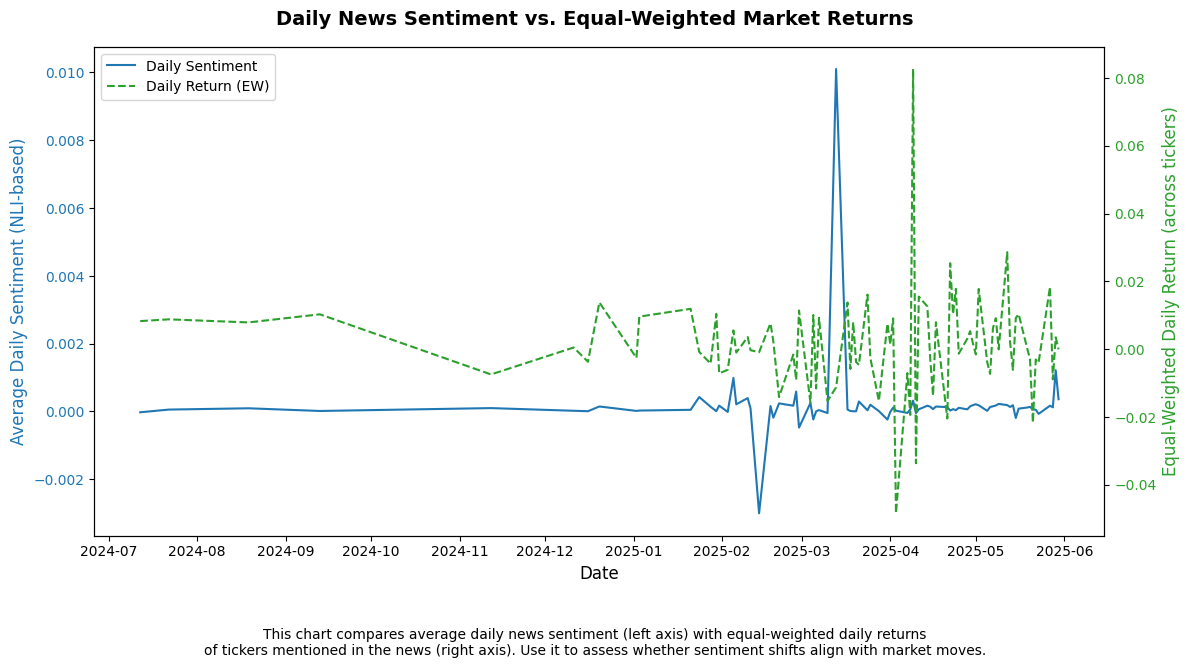

,DATE,DAILY_SENTIMENT,RETURN
0,2024-07-12,-0.000025,0.008249
1,2024-07-22,0.000055,0.008769
2,2024-08-19,0.000093,0.007860
3,2024-09-13,0.000014,0.010250
4,2024-11-12,0.000099,-0.007491
5,2024-12-11,0.000020,0.000451
6,2024-12-16,0.000007,-0.003750
7,2024-12-20,0.000146,0.013769
8,2025-01-02,0.000016,-0.002621
9,2025-01-03,0.000026,0.009577


In [5]:
# CODE HERE
# Use as many coding cells as you need
# 1) Convert publication date to datetime and group by day
# ========================
# 1) Daily sentiment (news)
# ========================
# Goal: aggregate a single DAILY_SENTIMENT per calendar day from news
warnings.filterwarnings("ignore", category=UserWarning, module="yfinance")

# 1) Daily sentiment from news -------------------------------------------------
df_news["DATE"] = (
    pd.to_datetime(df_news["PUBLICATION_DATE"], utc=True, errors="coerce")
      .dt.tz_convert(None)
      .dt.normalize()
)

df_sentiment = (
    df_news.groupby("DATE", as_index=False)["SENTIMENT"]
           .mean()
           .rename(columns={"SENTIMENT": "DAILY_SENTIMENT"})
)

# 2) Download prices for relevant tickers (robust) ----------------------------
tickers = sorted(set(df_news["TICKER"].dropna().astype(str)))
if len(tickers) == 0:
    raise ValueError("No tickers found in df_news['TICKER'].")

start_date = (df_sentiment["DATE"].min() - pd.Timedelta(days=3)).strftime("%Y-%m-%d")
end_date   = (df_sentiment["DATE"].max() + pd.Timedelta(days=3)).strftime("%Y-%m-%d")

def chunks(seq, size):
    for i in range(0, len(seq), size):
        yield seq[i:i+size]

def exponential_backoff_sleep(attempt, base=1.5, jitter=0.4):
    # sleep ~ base^attempt plus jitter
    delay = (base ** attempt) + random.uniform(0, jitter)
    time.sleep(delay)

def download_prices_chunked(tickers_list, start, end, chunk_size=50, retries=3):
    """
    Downloads prices in small chunks (sequential) and retries missing tickers individually.
    Returns:
      combined: DataFrame with MultiIndex columns (ticker, field)
      failed:   set of tickers that failed after all retries
    """
    per_ticker = {}

    # 2a) Chunked bulk downloads (sequential, threads=False)
    for chunk in chunks(tickers_list, chunk_size):
        try:
            df = yf.download(
                chunk, start=start, end=end,
                auto_adjust=False, group_by="ticker",
                threads=False, progress=False
            )
        except Exception as e:
            df = pd.DataFrame()

        if df.empty:
            continue

        if isinstance(df.columns, pd.MultiIndex):
            present = set(df.columns.get_level_values(0))
            for t in chunk:
                if t in present:
                    per_ticker[t] = df[t].copy()
        else:
            # single-ticker case
            t0 = chunk[0]
            per_ticker[t0] = df.copy()

    # Determine missing after chunked step
    missing = [t for t in tickers_list if t not in per_ticker]

    # 2b) Retry missing tickers individually with backoff
    for t in missing:
        ok = False
        for k in range(retries):
            try:
                df = yf.download(
                    t, start=start, end=end,
                    auto_adjust=False, group_by="ticker",
                    threads=False, progress=False
                )
                if not df.empty:
                    per_ticker[t] = df.copy()
                    ok = True
                    break
            except Exception:
                pass
            exponential_backoff_sleep(k)
        if not ok:
            print(f"[yfinance] Failed after retries: {t}")

    if not per_ticker:
        return pd.DataFrame(), set(tickers_list)

    combined = pd.concat(per_ticker, axis=1)  # MultiIndex (ticker, field)
    failed = set(tickers_list) - set(per_ticker.keys())
    return combined, failed

prices, failed_tickers = download_prices_chunked(
    tickers, start_date, end_date, chunk_size=40, retries=3
)

if prices.empty:
    raise ValueError("No price data returned by yfinance for the requested range.")

if failed_tickers:
    print(f"[info] Skipped tickers due to download failures: {sorted(failed_tickers)}")

# 3) Build Adj Close matrix ----------------------------------------------------
def get_adj_close_matrix(df_yf, tickers_list):
    if not isinstance(df_yf.columns, pd.MultiIndex):
        if "Adj Close" in df_yf.columns:
            adj = df_yf[["Adj Close"]].copy()
        else:
            adj = df_yf[["Close"]].copy()
        name = tickers_list[0] if len(tickers_list) == 1 else "ASSET"
        adj.columns = [name]
        return adj

    frames = []
    for t in tickers_list:
        if t in df_yf.columns.get_level_values(0):
            if (t, "Adj Close") in df_yf.columns:
                s = df_yf[(t, "Adj Close")].rename(t)
            elif (t, "Close") in df_yf.columns:
                s = df_yf[(t, "Close")].rename(t)
            else:
                continue
            frames.append(s)
    if not frames:
        raise ValueError("Could not find 'Adj Close' or 'Close' for any ticker.")
    return pd.concat(frames, axis=1)

valid_tickers = [t for t in tickers if t not in failed_tickers]
adj_close = get_adj_close_matrix(prices, valid_tickers).dropna(axis=1, how="all")

# 4) Returns per ticker & equal-weighted market proxy -------------------------
ret = adj_close.pct_change(fill_method=None)  # explicit to avoid FutureWarning
market_return = ret.mean(axis=1, skipna=True).rename("RETURN")

# 5) Align dates and merge with sentiment -------------------------------------
mkt = (
    market_return
    .to_frame()
    .reset_index()
    .rename(columns={"index": "DATE", "Date": "DATE"})
)
mkt["DATE"] = pd.to_datetime(mkt["DATE"]).dt.normalize()

df_compare = (
    pd.merge(df_sentiment, mkt, on="DATE", how="inner")
      .sort_values("DATE")
      .dropna(subset=["RETURN"])
)

# 6) Plot: dual y-axis (sentiment vs equal-weighted return) -------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Average Daily Sentiment (NLI-based)", color="tab:blue", fontsize=12)
line1, = ax1.plot(
    df_compare["DATE"],
    df_compare["DAILY_SENTIMENT"],
    color="tab:blue",
    label="Daily Sentiment"
)
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Equal-Weighted Daily Return (across tickers)", color="tab:green", fontsize=12)
line2, = ax2.plot(
    df_compare["DATE"],
    df_compare["RETURN"],
    color="tab:green",
    linestyle="--",
    label="Daily Return (EW)"
)
ax2.tick_params(axis="y", labelcolor="tab:green")

fig.suptitle("Daily News Sentiment vs. Equal-Weighted Market Returns", fontsize=14, fontweight="bold")
fig.text(
    0.5, -0.05,
    "This chart compares average daily news sentiment (left axis) with equal-weighted daily returns\n"
    "of tickers mentioned in the news (right axis). Use it to assess whether sentiment shifts align with market moves.",
    ha="center", va="top", fontsize=10
)

lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

fig.tight_layout()
plt.show()

# 7) Inspect merged data -------------------------------------------------------
display(df_compare.head(10))

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


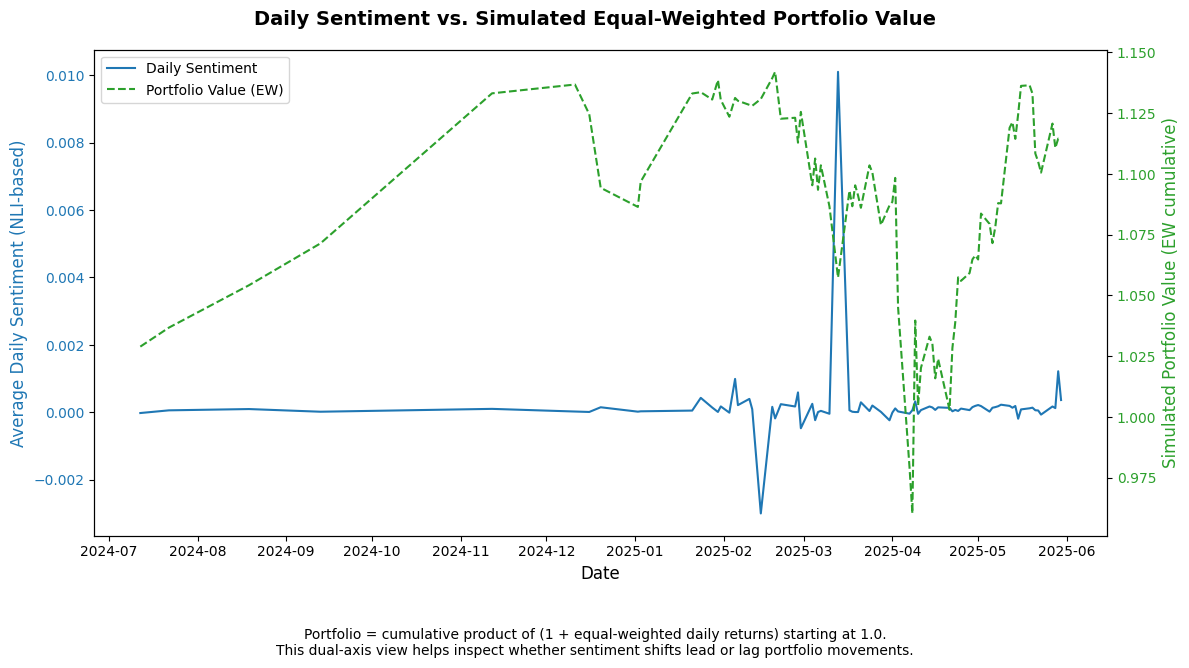

,DATE,DAILY_SENTIMENT,PORTFOLIO_VALUE
0,2024-07-12,-0.000025,1.028955
1,2024-07-22,0.000055,1.036775
2,2024-08-19,0.000093,1.054208
3,2024-09-13,0.000014,1.071435
4,2024-11-12,0.000099,1.133169
5,2024-12-11,0.000020,1.136796
6,2024-12-16,0.000007,1.124571
7,2024-12-20,0.000146,1.094308
8,2025-01-02,0.000016,1.086441
9,2025-01-03,0.000026,1.096846


In [6]:
# CODE HERE
# Use as many coding cells as you need
# 1) Build a simple “market portfolio” from equal-weighted daily returns
#    Start at 1.0 and compound forward: V_t = V_{t-1} * (1 + r_t)
portfolio = (
    (1.0 + market_return.fillna(0.0)).cumprod()
    .rename("PORTFOLIO_VALUE")
)

# 2) Align dates and merge with daily sentiment
port = (
    portfolio.to_frame()
             .reset_index()
             .rename(columns={"index":"DATE", "Date":"DATE"})
)
port["DATE"] = pd.to_datetime(port["DATE"]).dt.normalize()

df_port_compare = (
    pd.merge(df_sentiment, port, on="DATE", how="inner")
      .sort_values("DATE")
)

# 3) Plot: dual y-axis (sentiment vs portfolio value)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis: Daily average sentiment (NLI-based)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Average Daily Sentiment (NLI-based)", color="tab:blue", fontsize=12)
l1, = ax1.plot(
    df_port_compare["DATE"],
    df_port_compare["DAILY_SENTIMENT"],
    color="tab:blue",
    label="Daily Sentiment"
)
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right axis: Portfolio value (cum. return of equal-weighted daily returns)
ax2 = ax1.twinx()
ax2.set_ylabel("Simulated Portfolio Value (EW cumulative)", color="tab:green", fontsize=12)
l2, = ax2.plot(
    df_port_compare["DATE"],
    df_port_compare["PORTFOLIO_VALUE"],
    color="tab:green",
    linestyle="--",
    label="Portfolio Value (EW)"
)
ax2.tick_params(axis="y", labelcolor="tab:green")

# Title + explanatory note
fig.suptitle("Daily Sentiment vs. Simulated Equal-Weighted Portfolio Value", fontsize=14, fontweight="bold")
fig.text(
    0.5, -0.05,
    "Portfolio = cumulative product of (1 + equal-weighted daily returns) starting at 1.0.\n"
    "This dual-axis view helps inspect whether sentiment shifts lead or lag portfolio movements.",
    ha="center", va="top", fontsize=10
)

# Combined legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

fig.tight_layout()
plt.show()

# 4) Preview the merged frame
display(df_port_compare.head(10))

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [7]:
# CODE HERE
# Use as many coding cells as you need
# --- Compute Sector-Level Sentiment and Returns (Feb–May, compare May) ---

# --- Compute Sector-Level Sentiment and Returns (Feb–May, compare May) ---
# Updated to use month-end "ME" everywhere (no deprecation warnings)

_meta = df_meta.copy()
_meta.columns = [c.upper() for c in _meta.columns]

# Pick a sector column robustly
_sector_col = None
for cand in ["SECTOR", "GICS_SECTOR", "SECTOR_NAME", "SECTOR_NAME_LONG"]:
    if cand in _meta.columns:
        _sector_col = cand
        break
if _sector_col is None:
    raise ValueError("No sector column found in df_meta. Expected one of: SECTOR, GICS_SECTOR, SECTOR_NAME.")

meta_sector = _meta[["TICKER", _sector_col]].dropna().drop_duplicates()
meta_sector = meta_sector.rename(columns={_sector_col: "SECTOR"})
meta_sector["TICKER"] = meta_sector["TICKER"].astype(str)

# 1) Prepare dates in news (ensure we have DATE at day granularity) -----------
df_news["DATE"] = (
    pd.to_datetime(df_news["PUBLICATION_DATE"], utc=True, errors="coerce")
      .dt.tz_convert(None)
      .dt.normalize()
)

# Month-end timestamps to align with monthly returns (use 'ME' explicitly)
df_news["DATE"] = (
    pd.to_datetime(df_news["PUBLICATION_DATE"], utc=True, errors="coerce")
      .dt.tz_convert(None)
      .dt.normalize()
)

# Month-end timestamps to align with monthly returns
df_news["MONTH"] = df_news["DATE"].dt.to_period("M").dt.to_timestamp("M")

# 2) Monthly returns per ticker (from adj_close) -------------------------------
# Use 'ME' for resampling (valid for resample)
monthly_prices = adj_close.resample("ME").last()
monthly_returns = monthly_prices.pct_change()

# Target: most recent MAY available in prices
available_mays = monthly_returns.index[monthly_returns.index.month == 5]
if len(available_mays) == 0:
    raise ValueError("No May found in monthly returns index.")
target_may = available_mays.max()
target_year = target_may.year

# Limit the analysis window to Feb–May of the target year
months_window = pd.period_range(f"{target_year}-02", f"{target_year}-05", freq="M").to_timestamp("M")

# 3) Sector-level monthly sentiment (Feb–May) ---------------------------------
news_w_sector = (
    df_news.merge(meta_sector, on="TICKER", how="left")
           .dropna(subset=["SECTOR"])
)

sector_monthly_sent = (
    news_w_sector[news_w_sector["MONTH"].isin(months_window)]
      .groupby(["SECTOR", "MONTH"], as_index=False)
      .agg(
          SENTIMENT=("SENTIMENT", "mean"),
          HEADLINES=("SENTIMENT", "size")  # optional: count of headlines
      )
)

# Nice pivot for inspection (avg sentiment Feb–May by sector)
sent_pivot = (
    sector_monthly_sent
      .pivot(index="SECTOR", columns="MONTH", values="SENTIMENT")
      .sort_index()
)
sent_pivot.columns = [c.strftime("%Y-%m") for c in sent_pivot.columns]  # pretty month labels

# 4) Sector-level MAY returns (equal-weight across tickers in sector) ---------
# Map tickers to sectors only for tickers present in prices
tickers_in_prices = set(adj_close.columns.astype(str))
meta_valid = meta_sector[meta_sector["TICKER"].isin(tickers_in_prices)]

# Ticker-level May returns (single row, index=ticker)
may_ret_by_ticker = monthly_returns.loc[target_may].dropna()
may_ret_by_ticker.index = may_ret_by_ticker.index.astype(str)

# Join to sectors
may_ret_with_sector = (
    pd.DataFrame({"TICKER": may_ret_by_ticker.index, "RETURN": may_ret_by_ticker.values})
      .merge(meta_valid, on="TICKER", how="left")
      .dropna(subset=["SECTOR"])
)

# Sector-level equal-weight return in May
sector_may_returns = (
    may_ret_with_sector
      .groupby("SECTOR", as_index=False)["RETURN"]
      .mean()
)

# 5) Sector-level MAY sentiment ----------------------------------------------
sector_may_sent = (
    sector_monthly_sent[sector_monthly_sent["MONTH"] == target_may]
      .loc[:, ["SECTOR", "SENTIMENT", "HEADLINES"]]
      .rename(columns={"SENTIMENT": "SENTIMENT_MAY", "HEADLINES": "HEADLINES_MAY"})
)

# 6) Comparison table: SECTOR, SENTIMENT (May), RETURN (May) ------------------
sector_compare = (
    sector_may_sent.merge(sector_may_returns, on="SECTOR", how="outer")
                   .rename(columns={"SENTIMENT_MAY": "SENTIMENT", "RETURN": "RETURN"})
                   .sort_values(["RETURN", "SENTIMENT"], ascending=False)
                   .reset_index(drop=True)
)

# 7) Correlation between May sentiment and May returns ------------------------
valid = sector_compare.dropna(subset=["SENTIMENT", "RETURN"])
corr = valid["SENTIMENT"].corr(valid["RETURN"]) if len(valid) >= 2 else np.nan

# 8) Display results -----------------------------------------------------------
print(f"Target window: Feb–May {target_year} | Target May: {target_may.date()}")
print("\nMonthly average sentiment by sector (Feb–May):")
display(sent_pivot)

print("\nSector comparison for May (sentiment vs return):")
display(sector_compare[["SECTOR", "SENTIMENT", "RETURN", "HEADLINES_MAY"]])

print(
    f"\nCorrelation (Pearson) between May sentiment and May returns: {corr:.4f}"
    if pd.notna(corr) else
    "\nCorrelation could not be computed (insufficient valid sectors)."
)



Target window: Feb–May 2025 | Target May: 2025-05-31

Monthly average sentiment by sector (Feb–May):


,2025-02,2025-03,2025-04,2025-05
SECTOR,,,,
Basic Materials,-0.000037,0.002569,0.000163,0.000131
Communication Services,NaN,0.000032,0.000132,0.000150
Consumer Cyclical,-0.000168,-0.000093,0.000072,0.001167
Consumer Defensive,NaN,-0.000815,-0.000134,0.000099
Energy,NaN,0.000042,0.000062,0.000121
Financial Services,0.000214,0.000147,0.000116,0.000069
Healthcare,0.000340,NaN,0.000211,0.000125
Industrials,0.000107,0.004820,0.000112,0.000144
Real Estate,0.000140,0.000031,0.000213,0.000211



Sector comparison for May (sentiment vs return):


,SECTOR,SENTIMENT,RETURN,HEADLINES_MAY
0,Technology,0.000265,0.075285,636
1,Industrials,0.000144,0.073894,539
2,Financial Services,0.000069,0.061068,453
3,Consumer Cyclical,0.001167,0.056382,409
4,Communication Services,0.000150,0.041527,144
5,Utilities,0.000164,0.032967,209
6,Basic Materials,0.000131,0.029613,135
7,Energy,0.000121,0.029434,172
8,Real Estate,0.000211,0.010360,188
9,Healthcare,0.000125,0.000100,446



Correlation (Pearson) between May sentiment and May returns: 0.2730


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


Sectors that had strong sentiment in the news were **Consumer Cyclical** (highest sentiment: 0.001167), **Technology** (0.000265), and **Industrials** (0.000144).

* **Technology** translated that positive news into the **highest return (7.5%)**, showing alignment between sentiment and market performance.
* **Industrials** also matched strong sentiment with a **7.4% return**.
* **Consumer Cyclical** looked excellent in the news but only delivered a **5.6% return**, suggesting that optimism didn’t fully materialize into market outperformance.


### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


Some sectors posted solid returns even though sentiment wasn’t particularly strong:

* **Financial Services** had only mild sentiment (0.000069) but achieved a **6.1% return**.
* **Utilities** sentiment was very low (0.000164), but the sector returned **3.3%**.
* **Energy** sentiment was neutral (0.000121), yet it returned **2.9%**.

This suggests that market performance in these sectors was driven by fundamentals or external factors not captured by news sentiment.



### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

No — investing based on sentiment alone would be risky. While **Technology and Industrials** show that positive sentiment can align with strong performance, examples like **Consumer Cyclical** (high sentiment but only moderate returns) and **Healthcare** (neutral sentiment and near-zero return) show that sentiment is not a reliable standalone predictor.
Market behavior is influenced by fundamentals, macroeconomic conditions, and investor positioning — sentiment provides context but not the full picture.


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

A robust test of a sentiment-driven strategy would involve:

1. **Backtesting** across multiple years and market cycles, not just one period, to see if sentiment consistently aligns with returns.
2. **Cross-validation by sector** — does sentiment work better in some industries (e.g., Tech) than others (e.g., Defensive sectors)?
3. **Alternative sentiment metrics** — compare average daily sentiment, weighted sentiment by volume of headlines, and sentiment momentum (change in sentiment).
4. **Portfolio simulation** — build long-short strategies (e.g., long high-sentiment sectors, short low-sentiment sectors) and evaluate risk-adjusted performance (Sharpe ratio, drawdowns).
5. **Control for confounding variables** — include macro factors (interest rates, oil prices, earnings announcements) to ensure sentiment adds unique predictive power.